In [1]:
from load_dataset.artgraph import ArtGraph
import torch_geometric.transforms as T
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch
from torch_geometric.nn import HeteroConv, GATConv
from torch.nn import Linear
import torch.nn.functional as F
from torch import nn
import os
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Model, ModelClassification
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
from model import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## UTILS

In [4]:
from utils.GraphLinkSplitter import GraphLinkSplitter
#useful function to avoid frequent generation of the splitted dataset (expensive computational cost)
def import_dataset(root, feat, fine_tuning, obj, device, val_size = 0.2, test_size = 0.1):
    fine_tuning_s = 'fine-tuning' if fine_tuning else ''
    if (not os.path.exists(root)) or (not list(filter(lambda x: x.endswith(f'{obj}_{feat}_{fine_tuning_s}.pt'),os.listdir(root)))):
        if not os.path.exists(root):
            os.makedirs(root)
        artgraph = ArtGraph(root = 'artgraph2multi_task', preprocess='constant', features = feat, fine_tuning=fine_tuning)
        data = artgraph[0]
        data = T.ToUndirected()(data)
        del data[(obj, 'artwork')]
        gls = GraphLinkSplitter(on=obj, seed = 1, val_size = val_size, test_size = test_size)
        train_data, val_data, test_data = gls.transform(data)
        torch.save(train_data, fr'{root}/train_data_{obj}_{feat}_{fine_tuning_s}.pt')
        torch.save(val_data, fr'{root}/val_data_{obj}_{feat}_{fine_tuning_s}.pt')
        torch.save(test_data, fr'{root}/test_data_{obj}_{feat}_{fine_tuning_s}.pt')
    else:
        train_data=torch.load(fr'{root}/train_data_{obj}_{feat}_{fine_tuning_s}.pt')
        val_data=torch.load(fr'{root}/val_data_{obj}_{feat}_{fine_tuning_s}.pt')
        test_data=torch.load(fr'{root}/test_data_{obj}_{feat}_{fine_tuning_s}.pt')
    return train_data.to(device), val_data.to(device), test_data.to(device)

In [5]:
#class to manage the dataset (artwork features-style)
class ClassificationDataSet(torch.utils.data.Dataset):
    def __init__(self, graph, sub = 'artwork', obj = 'style'):
        self.graph = graph
        self.data = graph[sub, obj].edge_label_index.T[graph[sub, obj].edge_label==1]
        self.sub = sub
        self.obj = obj
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,0], self.graph[self.sub].x[self.data[idx,0]], self.data[idx, 1]
    
    def get_links(self):
        return pd.DataFrame(self.data.cpu().numpy(), columns = [self.sub, self.obj])

In [6]:
#to avoid class imbalance
def get_sampler(links, obj):
    unique, counts = np.unique(links[obj], return_counts = True)
    weights = [sum(counts) / c for c in counts]
    example_weights = [weights[e] for e in links[obj]]
    return WeightedRandomSampler(example_weights, links[obj].shape[0], replacement=True)

In [7]:
#to manage the training phase
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0.001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, current_loss):
        if self.best_loss == None:
            self.best_loss = current_loss
        elif (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait = self.wait + 1
            print(f"INFO: Early stopping counter {self.wait} of {self.patience}")
            if self.wait >= self.patience:
                self.early_stop = True

In [8]:
#training function
#TIPS: if you need a new one, take this structure and change just the internal loop, depending on the task
def fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 100,
              update_graph = False):
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_epoch=0
    
    stop = False
    for epoch in range(1, num_epochs + 1):
        if stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*120)

        data_loader = None
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = copy.deepcopy(validation_loader)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idxs, inputs, labels in tqdm(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(data_loader.dataset.graph.x_dict, data_loader.dataset.graph.edge_index_dict, inputs)
                    _, preds = torch.max(nn.Softmax(dim = 1)(outputs), 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if update_graph and phase == 'val':
                    data_loader.dataset.graph[data_loader.dataset.sub, data_loader.dataset.obj].edge_index = \
                        torch.hstack([data_loader.dataset.graph[data_loader.dataset.sub, data_loader.dataset.obj]\
                                                                     .edge_index,
                                                                 torch.Tensor([idxs.tolist(), preds.cpu().tolist()]).to(device)]).type(torch.long)
                    #artwork-task node
            epoch_loss = running_loss / (len(data_loader) * data_loader.batch_size)
            epoch_acc = running_corrects.double() / (len(data_loader) * data_loader.batch_size)
                
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model = copy.deepcopy(model)
                
                
            if phase == 'val':
                scheduler.step(epoch_acc.item())
            if phase == 'val':
                early_stop(-epoch_acc.item())
                print('-'*120, end = '\n\n')
                stop=early_stop.early_stop
                
                
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best epoch: {best_epoch:03d}')

    # load best model 
    return best_model, best_acc

In [9]:
#for metrics
def get_topk(k, artwork, probabilities):
    p = sorted(list(map(lambda x: (x[1], x[0], ), enumerate(probabilities))), reverse = True)
    ans = []
    for idx in range(k):
        ans.append((artwork, p[idx][1], ))
    return ans

In [10]:
#to perform graph update, during the testing phase
def add_links(graph, sub, obj, artworks, outputs, topk, device = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device == None else device
    work_graph = copy.deepcopy(graph)
    zipped = list(zip(artworks.tolist(), outputs.cpu().tolist()))
    top_task_pairs = list(map(lambda x: get_topk(topk, x[0], x[1]), zipped))
    top_task_pairs = torch.Tensor(top_task_pairs).type(torch.long)
    top_task_pairs = top_task_pairs.reshape(top_task_pairs.size(0) * top_task_pairs.size(1), top_task_pairs.size(2)).T
    work_graph[sub, obj].edge_index = torch.hstack([work_graph[sub, obj].edge_index.cpu(), top_task_pairs]).to(device)
    return work_graph

In [11]:
#test function
def test(model, test_loader, update_graph=True, track_history = False, topk = 1):
    corrects = 0
    tot_pred = None
    tot_lab = []
    history = []
    for idxs, inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(test_loader.dataset.graph.x_dict, test_loader.dataset.graph.edge_index_dict, inputs)
            outputs = nn.Softmax(dim = 1)(outputs)
            if tot_pred is None:
                tot_pred = outputs.cpu()
            else:
                tot_pred = torch.vstack([tot_pred, outputs.cpu()])
            tot_lab += labels.cpu().tolist()
        if update_graph:
            test_loader.dataset.graph = add_links(test_loader.dataset.graph,
                                                     test_loader.dataset.sub,
                                                     test_loader.dataset.obj,
                                                     idxs,
                                                     outputs,
                                                     topk,
                                                    )
        if track_history:
            lab_pred = torch.max(outputs, dim = 1)[1]
            history.append(((lab_pred == labels).sum() / labels.size(0)).item())
    
    if track_history:
        return tot_lab, tot_pred, history
    return tot_lab, tot_pred

## NORMAL LEARNING

In [12]:
#normal learning-> without updating the graph
batch_size = 128
update_graph = False
res = {}
if not os.path.exists('res_baseline_for_multitask/normal'):
    os.makedirs('res_baseline_for_multitask/normal')
for task in ('style', 'genre', 'emotion'):
    print(f"{'*'*50}{task.upper()}{'*'*50}")
    train_data, val_data, test_data = import_dataset(root = 'dataset_multi_task', feat='vit', fine_tuning=True,
                                                                 obj=task, device=device)
    model = ModelClassification(train_data, hidden_channels = 128,
                           obj= task, head_num_layers = 5, gnn_activation = nn.Tanh(),
                           head_activation = nn.LeakyReLU, shared = True, gnn_mean = False, bnorm = False,
                           drop_rate = 0.25).to(device)
    
    train_dataset = ClassificationDataSet(train_data, obj = task)
    val_dataset = ClassificationDataSet(val_data, obj = task)
    test_dataset = ClassificationDataSet(test_data, obj = task)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    #initialize encoders parameters
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max', min_lr = 1e-7, verbose = True, factor = .5, patience = 2,
                                               threshold = 1e-4)
    early_stop= EarlyStopping(patience = 7, min_delta = -1e-4)
    best_model, best_acc=fine_tune(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 50,
                                  update_graph = False)
    torch.save(best_model, fr'res_baseline_for_multitask/normal/{task}.pt')
    res[task] = best_acc.item()

**************************************************STYLE**************************************************


D:\Anaconda\envs\tesi\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:53: UserWarning: There exist node types ({'artwork'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:09<00:00, 37.02it/s]


train Loss: 2.0865 Acc: 0.3365


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.40it/s]


val Loss: 1.6145 Acc: 0.4654
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.92it/s]


train Loss: 1.5846 Acc: 0.4712


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.03it/s]


val Loss: 1.4877 Acc: 0.5060
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.54it/s]


train Loss: 1.4719 Acc: 0.5074


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 91.81it/s]


val Loss: 1.4286 Acc: 0.5178
------------------------------------------------------------------------------------------------------------------------

Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.49it/s]


train Loss: 1.4183 Acc: 0.5244


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.31it/s]


val Loss: 1.3838 Acc: 0.5322
------------------------------------------------------------------------------------------------------------------------

Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.99it/s]


train Loss: 1.3747 Acc: 0.5367


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.22it/s]


val Loss: 1.3504 Acc: 0.5416
------------------------------------------------------------------------------------------------------------------------

Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.48it/s]


train Loss: 1.3379 Acc: 0.5470


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.34it/s]


val Loss: 1.3309 Acc: 0.5538
------------------------------------------------------------------------------------------------------------------------

Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.80it/s]


train Loss: 1.3055 Acc: 0.5569


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.99it/s]


val Loss: 1.3285 Acc: 0.5517
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 57.23it/s]


train Loss: 1.2716 Acc: 0.5683


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.24it/s]


val Loss: 1.3023 Acc: 0.5610
------------------------------------------------------------------------------------------------------------------------

Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.78it/s]


train Loss: 1.2454 Acc: 0.5771


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 91.15it/s]


val Loss: 1.2829 Acc: 0.5708
------------------------------------------------------------------------------------------------------------------------

Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.20it/s]


train Loss: 1.2187 Acc: 0.5848


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.46it/s]


val Loss: 1.3012 Acc: 0.5645
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 57.05it/s]


train Loss: 1.1884 Acc: 0.5928


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.50it/s]


val Loss: 1.2681 Acc: 0.5690
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.50it/s]


train Loss: 1.1658 Acc: 0.6009


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.63it/s]


val Loss: 1.2705 Acc: 0.5747
------------------------------------------------------------------------------------------------------------------------

Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.63it/s]


train Loss: 1.1381 Acc: 0.6111


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.38it/s]


val Loss: 1.2582 Acc: 0.5751
------------------------------------------------------------------------------------------------------------------------

Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.49it/s]


train Loss: 1.1157 Acc: 0.6150


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.08it/s]


val Loss: 1.2159 Acc: 0.5857
------------------------------------------------------------------------------------------------------------------------

Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.23it/s]


train Loss: 1.0890 Acc: 0.6257


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.42it/s]


val Loss: 1.2296 Acc: 0.5847
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.07it/s]


train Loss: 1.0677 Acc: 0.6309


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.44it/s]


val Loss: 1.2147 Acc: 0.5878
------------------------------------------------------------------------------------------------------------------------

Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.36it/s]


train Loss: 1.0407 Acc: 0.6416


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.78it/s]


val Loss: 1.2088 Acc: 0.5915
------------------------------------------------------------------------------------------------------------------------

Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.46it/s]


train Loss: 1.0157 Acc: 0.6484


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.24it/s]


val Loss: 1.2143 Acc: 0.5916
------------------------------------------------------------------------------------------------------------------------

Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.89it/s]


train Loss: 0.9984 Acc: 0.6544


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.66it/s]


val Loss: 1.2269 Acc: 0.5844
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.94it/s]


train Loss: 0.9742 Acc: 0.6624


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.17it/s]


val Loss: 1.1742 Acc: 0.6060
------------------------------------------------------------------------------------------------------------------------

Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.73it/s]


train Loss: 0.9514 Acc: 0.6695


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.00it/s]


val Loss: 1.2350 Acc: 0.5846
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.03it/s]


train Loss: 0.9234 Acc: 0.6782


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.94it/s]


val Loss: 1.1935 Acc: 0.6015
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.49it/s]


train Loss: 0.9068 Acc: 0.6829


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.23it/s]


val Loss: 1.2008 Acc: 0.5987
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.90it/s]


train Loss: 0.8431 Acc: 0.7052


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.63it/s]


val Loss: 1.1483 Acc: 0.6197
------------------------------------------------------------------------------------------------------------------------

Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.50it/s]


train Loss: 0.8244 Acc: 0.7125


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.92it/s]


val Loss: 1.1415 Acc: 0.6215
------------------------------------------------------------------------------------------------------------------------

Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.35it/s]


train Loss: 0.7998 Acc: 0.7197


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.71it/s]


val Loss: 1.1489 Acc: 0.6225
------------------------------------------------------------------------------------------------------------------------

Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.32it/s]


train Loss: 0.7842 Acc: 0.7238


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.00it/s]


val Loss: 1.1465 Acc: 0.6236
------------------------------------------------------------------------------------------------------------------------

Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.71it/s]


train Loss: 0.7669 Acc: 0.7296


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.55it/s]


val Loss: 1.1482 Acc: 0.6255
------------------------------------------------------------------------------------------------------------------------

Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.84it/s]


train Loss: 0.7482 Acc: 0.7367


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.62it/s]


val Loss: 1.1628 Acc: 0.6268
------------------------------------------------------------------------------------------------------------------------

Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.45it/s]


train Loss: 0.7339 Acc: 0.7410


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.47it/s]


val Loss: 1.1815 Acc: 0.6216
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.86it/s]


train Loss: 0.7170 Acc: 0.7442


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.43it/s]


val Loss: 1.1747 Acc: 0.6232
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.77it/s]


train Loss: 0.7015 Acc: 0.7534


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.35it/s]


val Loss: 1.1875 Acc: 0.6239
Epoch 00032: reducing learning rate of group 0 to 2.5000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.76it/s]


train Loss: 0.6727 Acc: 0.7599


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.64it/s]


val Loss: 1.1676 Acc: 0.6349
------------------------------------------------------------------------------------------------------------------------

Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.28it/s]


train Loss: 0.6609 Acc: 0.7667


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.50it/s]


val Loss: 1.1689 Acc: 0.6337
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.90it/s]


train Loss: 0.6500 Acc: 0.7706


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.35it/s]


val Loss: 1.1867 Acc: 0.6330
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.80it/s]


train Loss: 0.6416 Acc: 0.7719


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.31it/s]


val Loss: 1.1790 Acc: 0.6304
Epoch 00036: reducing learning rate of group 0 to 1.2500e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.92it/s]


train Loss: 0.6363 Acc: 0.7741


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.91it/s]


val Loss: 1.1610 Acc: 0.6358
------------------------------------------------------------------------------------------------------------------------

Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.39it/s]


train Loss: 0.6228 Acc: 0.7803


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 90.10it/s]


val Loss: 1.1679 Acc: 0.6362
------------------------------------------------------------------------------------------------------------------------

Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.23it/s]


train Loss: 0.6212 Acc: 0.7792


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.32it/s]


val Loss: 1.1672 Acc: 0.6369
------------------------------------------------------------------------------------------------------------------------

Epoch 40/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.18it/s]


train Loss: 0.6167 Acc: 0.7806


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.17it/s]


val Loss: 1.1648 Acc: 0.6350
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 41/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.73it/s]


train Loss: 0.6146 Acc: 0.7812


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.51it/s]


val Loss: 1.1716 Acc: 0.6343
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 42/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.75it/s]


train Loss: 0.6021 Acc: 0.7858


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.46it/s]


val Loss: 1.1755 Acc: 0.6370
------------------------------------------------------------------------------------------------------------------------

Epoch 43/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.04it/s]


train Loss: 0.5989 Acc: 0.7868


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.22it/s]


val Loss: 1.1741 Acc: 0.6373
------------------------------------------------------------------------------------------------------------------------

Epoch 44/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.06it/s]


train Loss: 0.5922 Acc: 0.7909


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.85it/s]


val Loss: 1.1786 Acc: 0.6383
------------------------------------------------------------------------------------------------------------------------

Epoch 45/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.72it/s]


train Loss: 0.5898 Acc: 0.7912


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.46it/s]


val Loss: 1.1770 Acc: 0.6382
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 46/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.70it/s]


train Loss: 0.5833 Acc: 0.7937


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.93it/s]


val Loss: 1.1795 Acc: 0.6377
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 47/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.10it/s]


train Loss: 0.5779 Acc: 0.7944


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.10it/s]


val Loss: 1.1865 Acc: 0.6382
Epoch 00047: reducing learning rate of group 0 to 6.2500e-06.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 48/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 56.93it/s]


train Loss: 0.5785 Acc: 0.7931


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.64it/s]


val Loss: 1.1699 Acc: 0.6409
------------------------------------------------------------------------------------------------------------------------

Epoch 49/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.50it/s]


train Loss: 0.5706 Acc: 0.7966


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.77it/s]


val Loss: 1.1712 Acc: 0.6373
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 50/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 55.78it/s]


train Loss: 0.5672 Acc: 0.8000


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.12it/s]


val Loss: 1.1835 Acc: 0.6386
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Best val Acc: 0.640931
Best epoch: 048
**************************************************GENRE**************************************************
Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.13it/s]


train Loss: 1.4514 Acc: 0.5688


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 61.28it/s]


val Loss: 1.0258 Acc: 0.6777
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.83it/s]


train Loss: 1.0550 Acc: 0.6691


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.43it/s]


val Loss: 0.9645 Acc: 0.6931
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.52it/s]


train Loss: 0.9866 Acc: 0.6836


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.08it/s]


val Loss: 0.9200 Acc: 0.7038
------------------------------------------------------------------------------------------------------------------------

Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.55it/s]


train Loss: 0.9575 Acc: 0.6925


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.62it/s]


val Loss: 0.9129 Acc: 0.7061
------------------------------------------------------------------------------------------------------------------------

Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.17it/s]


train Loss: 0.9351 Acc: 0.7000


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.15it/s]


val Loss: 0.8996 Acc: 0.7095
------------------------------------------------------------------------------------------------------------------------

Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 59.97it/s]


train Loss: 0.9107 Acc: 0.7038


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.35it/s]


val Loss: 0.8876 Acc: 0.7135
------------------------------------------------------------------------------------------------------------------------

Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.30it/s]


train Loss: 0.8945 Acc: 0.7091


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.58it/s]


val Loss: 0.8790 Acc: 0.7147
------------------------------------------------------------------------------------------------------------------------

Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.58it/s]


train Loss: 0.8782 Acc: 0.7141


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.61it/s]


val Loss: 0.8732 Acc: 0.7166
------------------------------------------------------------------------------------------------------------------------

Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 59.83it/s]


train Loss: 0.8624 Acc: 0.7184


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.22it/s]


val Loss: 0.8650 Acc: 0.7188
------------------------------------------------------------------------------------------------------------------------

Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.97it/s]


train Loss: 0.8455 Acc: 0.7211


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.01it/s]


val Loss: 0.8608 Acc: 0.7171
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.17it/s]


train Loss: 0.8343 Acc: 0.7271


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.77it/s]


val Loss: 0.8532 Acc: 0.7242
------------------------------------------------------------------------------------------------------------------------

Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.10it/s]


train Loss: 0.8189 Acc: 0.7313


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.85it/s]


val Loss: 0.8497 Acc: 0.7220
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.40it/s]


train Loss: 0.8069 Acc: 0.7350


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.99it/s]


val Loss: 0.8430 Acc: 0.7233
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.76it/s]


train Loss: 0.7955 Acc: 0.7371


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.92it/s]


val Loss: 0.8418 Acc: 0.7238
Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 59.76it/s]


train Loss: 0.7594 Acc: 0.7499


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.25it/s]


val Loss: 0.8265 Acc: 0.7303
------------------------------------------------------------------------------------------------------------------------

Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.83it/s]


train Loss: 0.7473 Acc: 0.7506


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.07it/s]


val Loss: 0.8245 Acc: 0.7317
------------------------------------------------------------------------------------------------------------------------

Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.56it/s]


train Loss: 0.7409 Acc: 0.7531


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.72it/s]


val Loss: 0.8214 Acc: 0.7328
------------------------------------------------------------------------------------------------------------------------

Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.37it/s]


train Loss: 0.7342 Acc: 0.7566


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.21it/s]


val Loss: 0.8173 Acc: 0.7322
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.83it/s]


train Loss: 0.7232 Acc: 0.7581


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.85it/s]


val Loss: 0.8142 Acc: 0.7342
------------------------------------------------------------------------------------------------------------------------

Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.24it/s]


train Loss: 0.7124 Acc: 0.7604


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.14it/s]


val Loss: 0.8185 Acc: 0.7316
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.13it/s]


train Loss: 0.7015 Acc: 0.7653


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.71it/s]


val Loss: 0.8136 Acc: 0.7361
------------------------------------------------------------------------------------------------------------------------

Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.37it/s]


train Loss: 0.6955 Acc: 0.7660


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.05it/s]


val Loss: 0.8143 Acc: 0.7328
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.15it/s]


train Loss: 0.6886 Acc: 0.7689


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.36it/s]


val Loss: 0.8148 Acc: 0.7346
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 59.02it/s]


train Loss: 0.6778 Acc: 0.7719


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.46it/s]


val Loss: 0.8145 Acc: 0.7332
Epoch 00024: reducing learning rate of group 0 to 2.5000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.46it/s]


train Loss: 0.6570 Acc: 0.7779


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.18it/s]


val Loss: 0.8029 Acc: 0.7397
------------------------------------------------------------------------------------------------------------------------

Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.22it/s]


train Loss: 0.6505 Acc: 0.7809


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.44it/s]


val Loss: 0.8057 Acc: 0.7398
------------------------------------------------------------------------------------------------------------------------

Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.33it/s]


train Loss: 0.6456 Acc: 0.7827


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.22it/s]


val Loss: 0.8016 Acc: 0.7404
------------------------------------------------------------------------------------------------------------------------

Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.41it/s]


train Loss: 0.6413 Acc: 0.7833


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.36it/s]


val Loss: 0.8037 Acc: 0.7408
------------------------------------------------------------------------------------------------------------------------

Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.53it/s]


train Loss: 0.6339 Acc: 0.7850


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.14it/s]


val Loss: 0.8067 Acc: 0.7409
------------------------------------------------------------------------------------------------------------------------

Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.90it/s]


train Loss: 0.6267 Acc: 0.7875


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 80.62it/s]


val Loss: 0.8030 Acc: 0.7410
------------------------------------------------------------------------------------------------------------------------

Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.31it/s]


train Loss: 0.6221 Acc: 0.7888


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.99it/s]


val Loss: 0.8039 Acc: 0.7403
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.87it/s]


train Loss: 0.6179 Acc: 0.7923


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.38it/s]


val Loss: 0.8066 Acc: 0.7407
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 59.43it/s]


train Loss: 0.6107 Acc: 0.7946


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.85it/s]


val Loss: 0.8034 Acc: 0.7427
------------------------------------------------------------------------------------------------------------------------

Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.78it/s]


train Loss: 0.6073 Acc: 0.7941


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.21it/s]


val Loss: 0.8101 Acc: 0.7401
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.56it/s]


train Loss: 0.5976 Acc: 0.7977


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.47it/s]


val Loss: 0.8079 Acc: 0.7410
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.70it/s]


train Loss: 0.5956 Acc: 0.7972


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.92it/s]


val Loss: 0.8141 Acc: 0.7399
Epoch 00036: reducing learning rate of group 0 to 1.2500e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.53it/s]


train Loss: 0.5890 Acc: 0.7989


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.23it/s]


val Loss: 0.8067 Acc: 0.7427
------------------------------------------------------------------------------------------------------------------------

Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 59.96it/s]


train Loss: 0.5840 Acc: 0.8019


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.77it/s]


val Loss: 0.8088 Acc: 0.7428
------------------------------------------------------------------------------------------------------------------------

Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.06it/s]


train Loss: 0.5758 Acc: 0.8024


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.43it/s]


val Loss: 0.8101 Acc: 0.7427
------------------------------------------------------------------------------------------------------------------------

Epoch 40/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.79it/s]


train Loss: 0.5754 Acc: 0.8035


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.12it/s]


val Loss: 0.8112 Acc: 0.7436
------------------------------------------------------------------------------------------------------------------------

Epoch 41/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.47it/s]


train Loss: 0.5721 Acc: 0.8061


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.10it/s]


val Loss: 0.8106 Acc: 0.7435
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 42/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.06it/s]


train Loss: 0.5707 Acc: 0.8061


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.19it/s]


val Loss: 0.8121 Acc: 0.7445
------------------------------------------------------------------------------------------------------------------------

Epoch 43/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.79it/s]


train Loss: 0.5659 Acc: 0.8078


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.43it/s]


val Loss: 0.8130 Acc: 0.7441
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 44/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.92it/s]


train Loss: 0.5629 Acc: 0.8079


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.85it/s]


val Loss: 0.8136 Acc: 0.7446
------------------------------------------------------------------------------------------------------------------------

Epoch 45/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.96it/s]


train Loss: 0.5633 Acc: 0.8092


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.49it/s]


val Loss: 0.8183 Acc: 0.7437
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 46/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.15it/s]


train Loss: 0.5636 Acc: 0.8066


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.39it/s]


val Loss: 0.8136 Acc: 0.7432
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 47/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.17it/s]


train Loss: 0.5571 Acc: 0.8087


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.60it/s]


val Loss: 0.8167 Acc: 0.7418
Epoch 00047: reducing learning rate of group 0 to 6.2500e-06.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 48/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.46it/s]


train Loss: 0.5526 Acc: 0.8104


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.43it/s]


val Loss: 0.8141 Acc: 0.7443
INFO: Early stopping counter 4 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 49/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.36it/s]


train Loss: 0.5478 Acc: 0.8139


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.14it/s]


val Loss: 0.8143 Acc: 0.7453
------------------------------------------------------------------------------------------------------------------------

Epoch 50/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 64.04it/s]


train Loss: 0.5485 Acc: 0.8138


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.46it/s]


val Loss: 0.8168 Acc: 0.7462
------------------------------------------------------------------------------------------------------------------------

Best val Acc: 0.746170
Best epoch: 050
**************************************************EMOTION**************************************************
Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 54.81it/s]


train Loss: 1.7204 Acc: 0.3942


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.53it/s]


val Loss: 1.5852 Acc: 0.4308
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 64.47it/s]


train Loss: 1.6051 Acc: 0.4274


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.10it/s]


val Loss: 1.5579 Acc: 0.4384
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.98it/s]


train Loss: 1.5782 Acc: 0.4354


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.36it/s]


val Loss: 1.5616 Acc: 0.4351
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.96it/s]


train Loss: 1.5649 Acc: 0.4406


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.26it/s]


val Loss: 1.5502 Acc: 0.4364
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.64it/s]


train Loss: 1.5514 Acc: 0.4426


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.10it/s]


val Loss: 1.5374 Acc: 0.4422
------------------------------------------------------------------------------------------------------------------------

Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.10it/s]


train Loss: 1.5422 Acc: 0.4480


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.36it/s]


val Loss: 1.5373 Acc: 0.4439
------------------------------------------------------------------------------------------------------------------------

Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.90it/s]


train Loss: 1.5336 Acc: 0.4486


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.29it/s]


val Loss: 1.5318 Acc: 0.4432
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.58it/s]


train Loss: 1.5237 Acc: 0.4536


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.93it/s]


val Loss: 1.5305 Acc: 0.4446
------------------------------------------------------------------------------------------------------------------------

Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.66it/s]


train Loss: 1.5164 Acc: 0.4557


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.71it/s]


val Loss: 1.5360 Acc: 0.4413
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.33it/s]


train Loss: 1.5102 Acc: 0.4597


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.01it/s]


val Loss: 1.5276 Acc: 0.4472
------------------------------------------------------------------------------------------------------------------------

Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.52it/s]


train Loss: 1.5048 Acc: 0.4600


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.47it/s]


val Loss: 1.5223 Acc: 0.4468
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.44it/s]


train Loss: 1.4978 Acc: 0.4604


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.15it/s]


val Loss: 1.5202 Acc: 0.4497
------------------------------------------------------------------------------------------------------------------------

Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.05it/s]


train Loss: 1.4896 Acc: 0.4658


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.67it/s]


val Loss: 1.5297 Acc: 0.4509
------------------------------------------------------------------------------------------------------------------------

Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.13it/s]


train Loss: 1.4819 Acc: 0.4686


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.36it/s]


val Loss: 1.5246 Acc: 0.4491
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.01it/s]


train Loss: 1.4754 Acc: 0.4718


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.99it/s]


val Loss: 1.5241 Acc: 0.4505
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.83it/s]


train Loss: 1.4695 Acc: 0.4715


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.38it/s]


val Loss: 1.5263 Acc: 0.4514
------------------------------------------------------------------------------------------------------------------------

Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.59it/s]


train Loss: 1.4590 Acc: 0.4781


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 78.15it/s]


val Loss: 1.5262 Acc: 0.4481
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.72it/s]


train Loss: 1.4529 Acc: 0.4769


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.05it/s]


val Loss: 1.5278 Acc: 0.4498
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.94it/s]


train Loss: 1.4466 Acc: 0.4787


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.99it/s]


val Loss: 1.5185 Acc: 0.4531
------------------------------------------------------------------------------------------------------------------------

Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.11it/s]


train Loss: 1.4390 Acc: 0.4826


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.81it/s]


val Loss: 1.5216 Acc: 0.4507
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.74it/s]


train Loss: 1.4288 Acc: 0.4870


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.78it/s]


val Loss: 1.5198 Acc: 0.4514
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.41it/s]


train Loss: 1.4208 Acc: 0.4903


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.21it/s]


val Loss: 1.5255 Acc: 0.4494
Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.29it/s]


train Loss: 1.3980 Acc: 0.4977


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.71it/s]


val Loss: 1.5334 Acc: 0.4487
INFO: Early stopping counter 4 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 60.28it/s]


train Loss: 1.3921 Acc: 0.5007


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.46it/s]


val Loss: 1.5354 Acc: 0.4465
INFO: Early stopping counter 5 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.24it/s]


train Loss: 1.3855 Acc: 0.5047


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.85it/s]


val Loss: 1.5356 Acc: 0.4468
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
INFO: Early stopping counter 6 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.44it/s]


train Loss: 1.3731 Acc: 0.5044


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.08it/s]

val Loss: 1.5277 Acc: 0.4491
INFO: Early stopping counter 7 of 7
------------------------------------------------------------------------------------------------------------------------

Best val Acc: 0.453125
Best epoch: 019


In [ ]:
res

In [ ]:
import json
with open('res_classification/results.json','w') as f:
    json.dump(res,f)

## TESTING

In [13]:
history_map = {}

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#plot confusion matrix
def plot_confusion_matrix(true, pred, task = None, strategy=None , labels = None, hop = 1):
    conf_mat = confusion_matrix(true, pred, normalize = 'true')
    sns.set(font_scale=1.5) # for label size
    fig, ax = plt.subplots(figsize = (12,12))
    
    ax = sns.heatmap(pd.DataFrame(conf_mat), annot = False, cmap = plt.cm.Blues,
                     xticklabels = labels,
                     yticklabels = labels,
                     square = True,
                     linewidths=.50)
    
    plt.show()
    if task:
        fig.savefig(f'{task}_{strategy}.svg')

In [15]:
def compute_topk(true, pred, k):
    #target data frame to compute topk
    df = pd.DataFrame(true, columns = ['true'])
    #useful dataframe to compute top k target for each artwork
    temp = pd.DataFrame(pd.DataFrame(pred).apply(lambda x: x.tolist(), axis = 1), columns = ['pred'])
    temp['temp'] = temp.pred.map(lambda x: list(range(len(x))))#for each artwork list of classes
    temp['temp'] = temp.apply(lambda x: list(zip(x['pred'], x['temp'])), axis = 1)#zip probabilities with classes
    temp['topk'] = temp['temp'].map(lambda x: list(sorted(x, reverse = True))[:k])#sorting
    df['topk'] = temp.topk.map(lambda x: list(map(lambda y: y[1], x)))#taking only classes
    
    df['cond'] = df.apply(lambda x: x['true'] in x['topk'], axis = 1)
    return df[df.cond].index.shape[0] / df.index.shape[0]
    

In [16]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.70it/s]


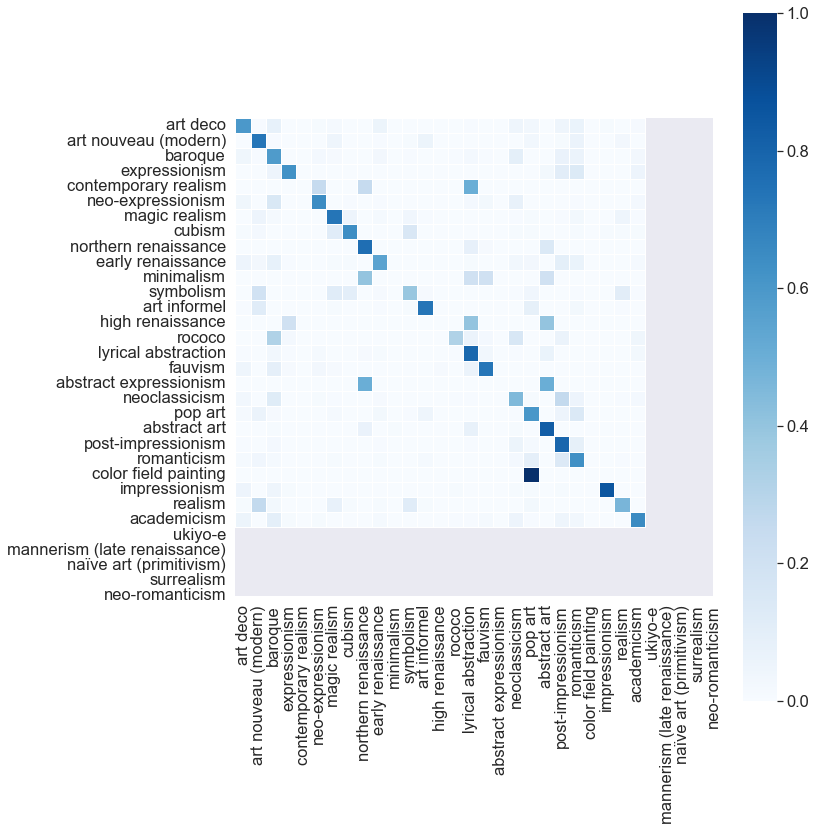

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.28it/s]


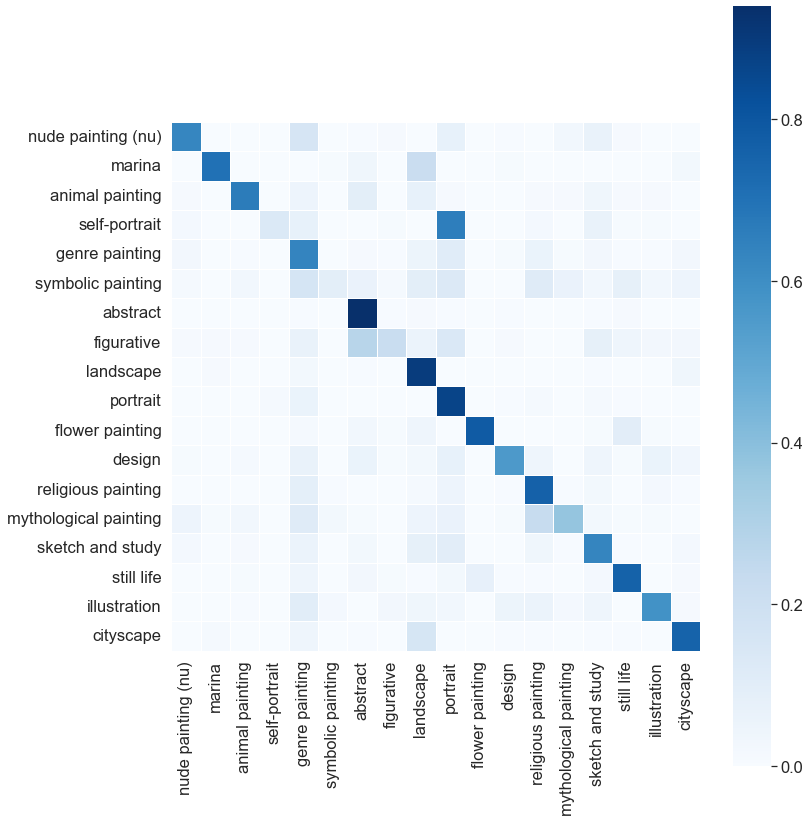

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 35.07it/s]


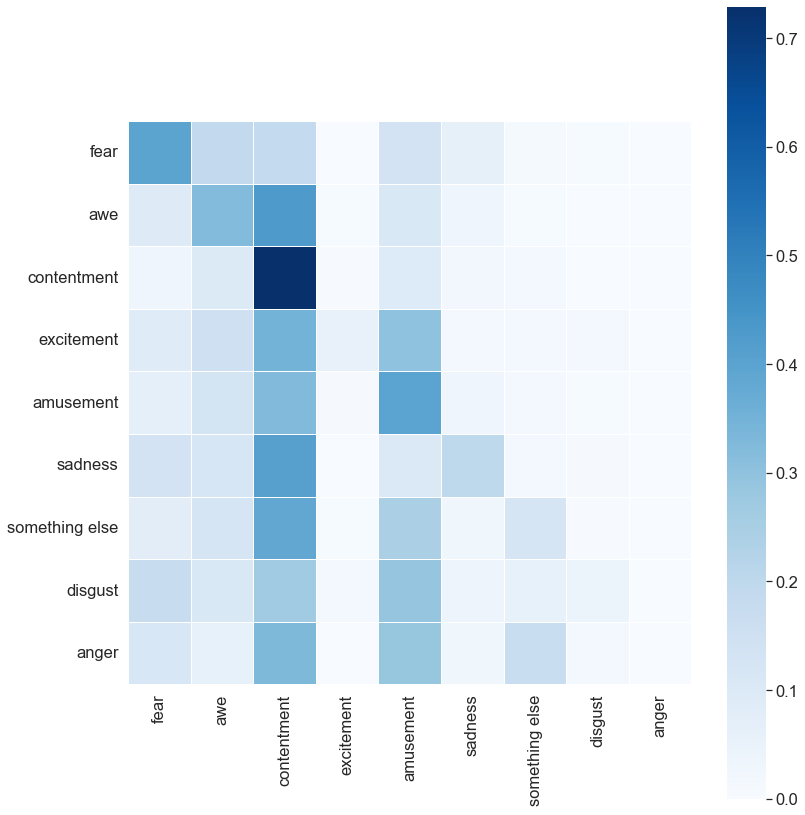

In [17]:
#testing without updating the graph
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_baseline_for_multitask/normal/{task}.pt').to(device)
    
    task2name = pd.read_csv(f'artgraph2multi_task/mapping/{task}_entidx2name.csv', names = ['idx','name'])
    names = task2name['name'].values
    
    test_data = torch.load(fr'dataset_multi_task/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, worker_init_fn=np.random.seed(1))
    
    true, pred, history = test(model, test_loader, update_graph = False, track_history = True)
    
    if task == 'genre':
        history_map['normal_no_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred, task = task, strategy = 'normal', labels = task2name['name'], hop = map_hop[task])
    #ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [18]:
results_df

,Top1,Top2,Macro-F1
style,0.644247,0.81768,0.524777
genre,0.74751,0.88831,0.625955
emotion,0.444155,0.658495,0.255079


In [19]:
test_data

HeteroData(
  artwork={ x=[65262, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 988] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 94] },
  (artwork, about, tag)={ edge_index=[2, 158629] },
  (artwork, createdby, artist)={ edge_index=[2, 45683] },
  (artwork, elicit, emotion)={
    edge_index=[2, 45683],
    edge_label=[58743],
    ed

In [ ]:
results_df.to_csv('res_classification/normal_no_update.csv')

In [ ]:
#testing updating the graph
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/normal/{task}.pt').to(device)
    
    task2name = pd.read_csv(f'artgraph2bestemotions/mapping/{task}_entidx2name.csv', names = ['idx','name'])
    
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                   drop_last=False)
    
    true, pred, history = test(model, test_loader, update_graph = True, track_history=True, topk = 1)
    
    if task == 'genre':
        history_map['normal_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred, task = task, strategy = 'update', labels = task2name['name'], hop = map_hop[task])
    #ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [ ]:
results_df

In [ ]:
results_df.to_csv('res_classification/normal_update.csv')